Set the matplotlib plotting options

Import generally used packages

Set the logging level

In [1]:
%matplotlib inline

import logging

import matplotlib.pyplot as plt
import numpy as np

from dynrat import set_logging_level


# loggin levels include
#   'error'
#   'warning'
#   'info'
#   'debug'

set_logging_level('warning')

### Load the cross-section geometry data and plot the cross section

`xs_csv` is the path the CSV file containing the cross section data.

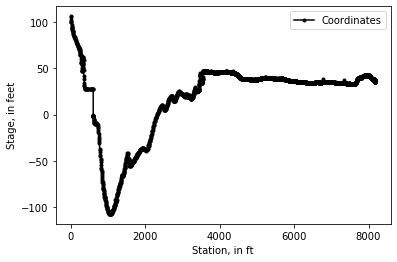

In [2]:
from dynrat.sect import CrossSect


xs_csv = 'data/vbms/site_07289000_cs_20110517.csv'

sect = CrossSect.from_csv(xs_csv)
_ = sect.plot()

### Load, subset, and plot the measured stage time series data from a CSV file obtained from Aquarius

In the next cell, the variables `event_start_date` and `event_end_date` define the beginning and ending of the period of the time series that is retained. 

`aq_stage_csv` on line 7 is the path to the CSV file from Aquarius which contains stage data.

Line 8 calls the `from_aq_csv` class method to load the stage time series from `aq_stage_csv`. The `interp_missing` keyword argument is set to `True` so missing observations will be linearly interpolated.

Line 9 subsets the data based on the beginning and ending dates defined by `event_start_date` and `event_end_date` initialized on lines 4 and 5.

Line 11 plots the stage time series.

Line 13 shows the number of null, or missing, observations. The result is shown in the output of the cell.

0

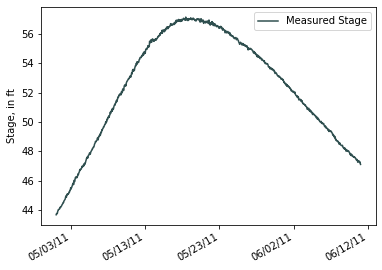

In [3]:
from dynrat.timeseries import MeasuredStageTimeSeries


event_start_date = '5/1/2011 00:00'
event_end_date = '6/11/2011 00:00'

aq_stage_csv = 'data/vbms/site_07289000_iv_s_Aquarius.csv'
measured_stage = MeasuredStageTimeSeries.from_aq_csv(aq_stage_csv, interp_missing=True)
measured_stage = measured_stage.subset_dt(event_start_date, event_end_date)

_ = measured_stage.plot()

measured_stage.null_obs()

### Load, subset, and plot the rated discharge time series data from a CSV file obtained from Aquarius

`aq_flow_csv` on line 4 is the path to the CSV file from Aquarius which contains discharge time series data.

Line 5 calls the `from_aq_csv` class method to load the discharge time series from `aq_flow_csv`. The `interp_missing` keyword argument is set to `True` so missing observations will be linearly interpolated.

Line 9 subsets the data based on the beginning and ending dates defined by `event_start_date` and `event_end_date` initialized earlier.

Line 11 plots the flow time series.

Line 13 shows the number of null, or missing, observations. The result is shown in the output of the cell.

0

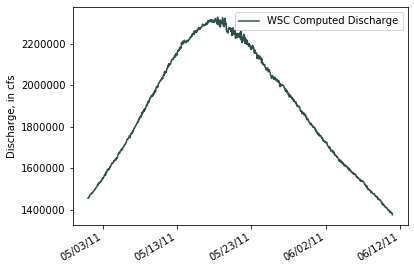

In [4]:
from dynrat.timeseries import RatedDischargeTimeSeries


aq_flow_csv = 'data/vbms/site_07289000_iv_q_Aquarius.csv'
rated_flow = RatedDischargeTimeSeries.from_aq_csv(aq_flow_csv, interp_missing=True)
rated_flow = rated_flow.subset_dt(event_start_date, event_end_date)
_ = rated_flow.plot()

rated_flow.null_obs()

### Load and subset the field measurement data, plot stage/discharge

`fm_rdb_path` on line 5 is the path to the RDB file which contains field measurement data.

On line 6, the field measurement data is loaded using the `read_nwis_rdb` function.

Subsets of the data are created on lines 8 and 9 using the `subset_dt` method.

A stage/discharge plot is created with the measured stage vs. rated discharge (line 12) and the stage vs. discharged measured in the field (line 13).

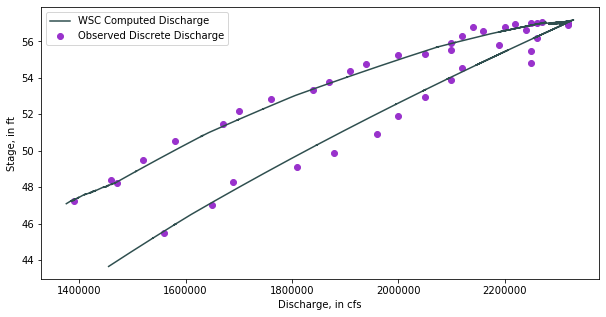

In [5]:
from dynrat.plot import stage_discharge_plot
from dynrat.timeseries import read_nwis_rdb


fm_rdb_path = 'data/vbms/site_07289000_fm_NWIS.txt'
observed_stage, observed_flow = read_nwis_rdb(fm_rdb_path)

observed_stage = observed_stage.subset_dt(event_start_date, event_end_date)
observed_flow = observed_flow.subset_dt(event_start_date, event_end_date)

fig, ax = plt.subplots(figsize=(10, 5))
_ = stage_discharge_plot(measured_stage, rated_flow, ax)
_ = stage_discharge_plot(observed_stage, observed_flow, ax)

### Plot top width and area time series

The measured stage time series and computed top width and area time series are plotted.

The `cross_section_plot` method of the measured stage object plots the time series using the previously initialized cross section object `sect`. The top width time series is plotted in line 5, with `'top width'` as an argument to the `cross_section_plot` method. Similarly, the area time series is plotted in line 9, but with passing `'area'` instead.

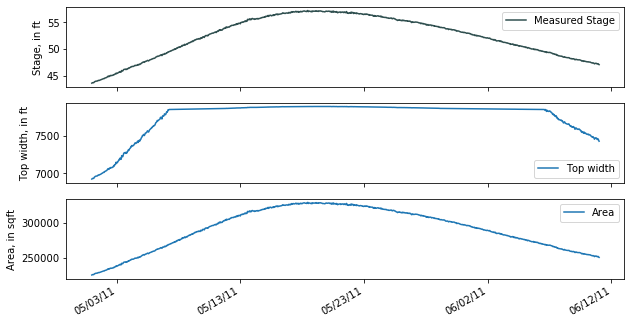

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))

_ = measured_stage.plot(ax1)

_ = measured_stage.cross_section_plot(sect, 'top width', ax=ax2)
_ = ax2.set_ylabel('Top width, in ft')
_ = ax2.set_xlabel('')

_ = measured_stage.cross_section_plot(sect, 'area', ax=ax3)
_ = ax3.set_ylabel('Area, in sqft')

### Initialize and plot the friction table

The stage and corresponding roughness values are initialized as Python lists in lines 4 and 5.

The friction table `frict` is initialized in line 7.

Line 9 plots the table.

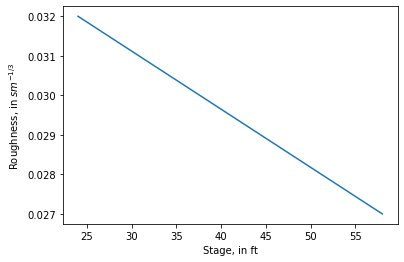

In [7]:
from dynrat.frict import TableFrict


stage = [24, 58]
roughness = [0.032, 0.027]

frict = TableFrict(stage, roughness)

_ = frict.plot()

### Compute the slope ratio

On line 11, the slope ratio is computed by the `r_slope` function and is stored in the `slope_ratio` variable.

The value of `slope_ratio` is displayed in the cell output on line 12.

In [8]:
from dynrat.rslope import r_slope

h_o = 23.00  # stage prior to start of typical flood
h_p = 36.72  # peak stage of typical flood
q_o = 625000  # flow prior to typical flood
q_p = 1050000  # peak flow of typical flood
t_diff = 21  # elapsed time of stage rise to peak stage in days

bed_slope = 0.00011

slope_ratio = r_slope(h_o, h_p, q_o, q_p, bed_slope, sect, t_diff)
slope_ratio

101.11210806866995

### Compute the discharge time series

Line 5 stores the time step of the stage time series in the `time_step` variable.

A DYNMOD solver, `QSolve`, is initialized as `q_solve` in line 7.

The time series solver, `QTimeSeries`, is initialized as `qts` in line 9.

The initial discharge value for the solution is stored in `q0` in line 11.

Line 12 computes the discharge time series.

In [9]:
from dynrat.dynmod import QSolve
from dynrat.solve import QTimeSeries


time_step = measured_stage.freq()

q_solve = QSolve(sect, frict, bed_slope, slope_ratio, time_step)

qts = QTimeSeries(q_solve)

q0 = rated_flow.values()[0]
computed_flow = qts.solve_ts(measured_stage, q0)

### Plot the discharge time series

The computed discharge time series is plotted with the rated discharge and field measurements in lines 3, 4, and 5.

The error of the computed discharge relative to the rated discharge is plotted in line 7.

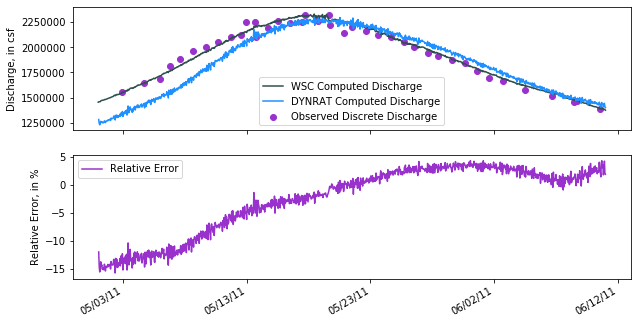

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

_ = rated_flow.plot(ax1)
_ = observed_flow.plot(ax1)
_ = computed_flow.plot(ax1)

_ = computed_flow.plot_relative_error(rated_flow, ax2)

### Plot computed stage and discharge

The next cell shows the stage vs. discharge plots of all three time series. 

Line 4 plots the computed discharge and sets the color and label for the line.

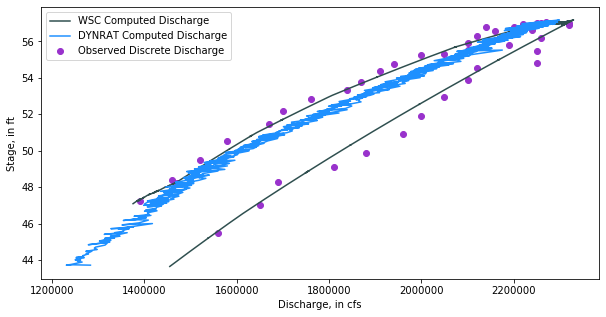

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
_ = stage_discharge_plot(measured_stage, rated_flow, ax)
_ = stage_discharge_plot(observed_stage, observed_flow, ax)
_ = stage_discharge_plot(measured_stage, computed_flow, ax, color='dodgerblue', label='DYNRAT Computed Discharge')

The output of the next cell shows the RMSE of the computed discharge.

In [12]:
computed_flow.rmse(rated_flow)

112331.54738389012

The mean relative error is shown in the output of the next cell.

In [13]:
computed_flow.mean_error(rated_flow, relative=True)

-2.553111355467833